# Model Evaluation and Fairness Analysis

In this notebook, we evaluate the performance and fairness of our model trained on the weighted data. The steps include:

1. **Data Loading:** Load the weighted dataset (`weighted_train.csv`).
2. **Data Preparation:** Split the data into training and testing sets and scale the features.
3. **Model Training:** Train a Logistic Regression model on the weighted data.
4. **Performance Evaluation:** Compute accuracy and print the classification report.
5. **Fairness Evaluation:** Convert the test set into an AIF360 BinaryLabelDataset and compute fairness metrics (Statistical Parity Difference and Disparate Impact).
6. **Visualization:** Plot the average positive prediction rate by the protected attribute (sex).

Let's get started!


## 1. Environment Setup and Data Loading

We begin by setting up our environment. Since this notebook is running from the `notebooks` folder, we move up one level to define our project root. Then we construct the absolute path to the weighted data file and load it.


In [7]:
import os
import sys
import pandas as pd

# Since the notebook is in the 'notebooks' folder, move up one level to get the project root.
current_dir = os.getcwd()
if os.path.basename(current_dir) == "notebooks":
    project_root = os.path.abspath(os.path.join(current_dir, ".."))
else:
    project_root = current_dir

print("Project root directory:", project_root)

# Construct the absolute path to the weighted data file.
weighted_csv_path = os.path.join(project_root, "data", "weighted_train.csv")
print("Looking for weighted data at:", weighted_csv_path)

# Check if the weighted data file exists.
if not os.path.exists(weighted_csv_path):
    sys.exit(f"Error: Weighted data file not found at {weighted_csv_path}.\n"
             "Please run 'python3 src/bias_mitigation.py' to generate weighted_train.csv before proceeding.")

# Load the weighted data.
df = pd.read_csv(weighted_csv_path)
print("Weighted data loaded. Shape:", df.shape)


Project root directory: /Users/stay-c/Desktop/AI_Fairness_Project
Looking for weighted data at: /Users/stay-c/Desktop/AI_Fairness_Project/data/weighted_train.csv
Weighted data loaded. Shape: (32561, 15)


## 2. Data Preparation

We assume the target column is named `income_binary`. Here, we separate the features from the target and split the data into training and testing sets using a 70-30 split.


In [8]:
from sklearn.model_selection import train_test_split

# Ensure the target column exists.
if 'income_binary' not in df.columns:
    sys.exit("Error: Expected target column 'income_binary' not found in weighted data.")

# Separate features (X) and target (y).
X = df.drop(['income_binary'], axis=1)
y = df['income_binary']

# Split the data into training (70%) and testing (30%) sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Data split into training and testing sets.")
print("Training set shape:", X_train.shape, "Test set shape:", X_test.shape)


Data split into training and testing sets.
Training set shape: (22792, 14) Test set shape: (9769, 14)


## 3. Feature Scaling and Model Training

Feature scaling is critical for many models. We standardize our features using `StandardScaler` and then train a Logistic Regression model as our baseline classifier on the weighted data.


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Scale features.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Logistic Regression model on the weighted data.
model = LogisticRegression(max_iter=2000)
model.fit(X_train_scaled, y_train)
print("Model trained on weighted data.")

# Predict on the test set.
predictions = model.predict(X_test_scaled)

# Evaluate model performance.
accuracy = accuracy_score(y_test, predictions)
print("\nModel Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, predictions))


Model trained on weighted data.

Model Accuracy: 0.8258777766403931
Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.94      0.89      7455
         1.0       0.71      0.45      0.55      2314

    accuracy                           0.83      9769
   macro avg       0.78      0.70      0.72      9769
weighted avg       0.81      0.83      0.81      9769



## 4. Fairness Evaluation

Next, we evaluate the fairness of our model. We ensure that the protected attribute `sex` is included in our features, and then we prepare a DataFrame that includes true and predicted labels.  
We convert this DataFrame into an AIF360 `BinaryLabelDataset` and compute fairness metrics:  
- **Statistical Parity Difference**  
- **Disparate Impact**

In our example, we assume that `sex = 1` is the privileged group (e.g., Male) and `sex = 0` is the unprivileged group (e.g., Female).


In [10]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric

# Check that the protected attribute 'sex' is in the features.
if 'sex' not in X.columns:
    sys.exit("Error: Protected attribute 'sex' not found in weighted data.")

# Prepare DataFrame for fairness evaluation.
X_test_df = pd.DataFrame(X_test, columns=X.columns)
X_test_df['true_label'] = y_test.values
X_test_df['pred_label'] = predictions

# Convert to an AIF360 BinaryLabelDataset.
dataset_true = BinaryLabelDataset(df=X_test_df, label_names=['true_label'], protected_attribute_names=['sex'])
dataset_pred = dataset_true.copy()
dataset_pred.labels = X_test_df['pred_label'].values.reshape(-1, 1)

# Compute fairness metrics.
fair_metric = ClassificationMetric(
    dataset_true,
    dataset_pred,
    privileged_groups=[{'sex': 1}],    # Privileged group: e.g., Male
    unprivileged_groups=[{'sex': 0}]   # Unprivileged group: e.g., Female
)

print("\nFairness Metrics on Weighted Model Predictions:")
print("Statistical Parity Difference:", fair_metric.statistical_parity_difference())
print("Disparate Impact:", fair_metric.disparate_impact())



Fairness Metrics on Weighted Model Predictions:
Statistical Parity Difference: -0.1754883749654449
Disparate Impact: 0.16342001686180982


## 5. Visualization of Group-Level Positive Prediction Rates

We calculate and visualize the average positive prediction rate for each group defined by the protected attribute `sex`.  
This helps us understand if the model's predictions differ significantly between the privileged and unprivileged groups.



Average positive prediction rate by group:
sex
0.0    0.034280
1.0    0.209769
Name: pred_label, dtype: float64


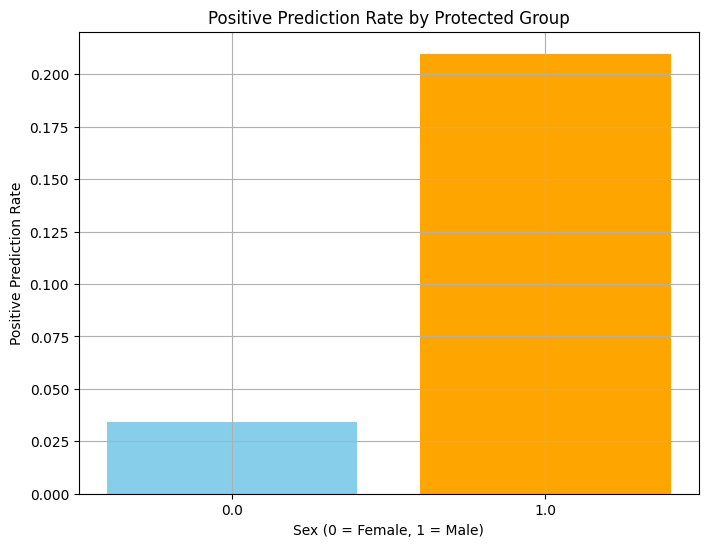

In [11]:
import matplotlib.pyplot as plt

# Calculate average positive prediction rate by protected group.
grouped = X_test_df.groupby('sex')['pred_label'].mean()
print("\nAverage positive prediction rate by group:")
print(grouped)

# Plot the positive prediction rates by group.
plt.figure(figsize=(8, 6))
plt.bar(grouped.index.astype(str), grouped.values, color=['skyblue', 'orange'])
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.ylabel('Positive Prediction Rate')
plt.title('Positive Prediction Rate by Protected Group')
plt.grid(True)
plt.show()


## Conclusion

In this notebook, we have:
- Loaded the weighted dataset and split it into training and testing sets.
- Scaled the features and trained a Logistic Regression model.
- Evaluated the model's performance with accuracy and a detailed classification report.
- Computed fairness metrics to assess bias in the model's predictions.
- Visualized the positive prediction rates by the protected attribute `sex`.

This comprehensive evaluation will help us understand both the predictive performance and fairness of our model, guiding further improvements if needed.
